In [11]:
import pandas as pd

# filename = "data/triangulated/2023-05-24-12:32:40.823901_P3-1-6-5_normalized.csv"
# filename = "/home/piotr/Documents/mgr/uwb-rs/data-processing/data/triangulated/2023-05-24-13:52:11.266488_P3-1-6-5_normalized_high_up.csv"
# filename = "data/triangulated/2023-05-24-14:35:08.828772P3-1-6-5_high_los.csv"
filename = "/home/piotr/Documents/mgr/uwb-rs/data-processing/data/triangulated/2023-06-23-13:55:53.175807slide-4anchors.csv"
df = pd.read_csv(filename)
df["timestamp"] = pd.to_datetime(df["timestamp"])

In [12]:
# Units conversion - m and m/s^2
df[["x", "y"]] /= 1000
df[["acc_x", "acc_y"]] *= 9.80665
df["reference_distance"] /= 1000

In [13]:
import numpy as np

dt = df["timestamp"].diff().mean().to_pytimedelta().microseconds/10**6

F = np.matrix([[1, 0, dt**2/2, 0      ],
               [0, 1, 0,       dt**2/2],
               [0, 0, 1,       0      ],
               [0, 0, 0,       1      ]])
H = np.matrix(np.eye(4))

Q = np.matrix(np.eye(4))
R = np.matrix(np.diag([df["x"].std()**2,df["y"].std()**2,df["acc_y"].std()**2,df["acc_z"].std()**2]))
P = np.matrix(np.eye(4))*10000
x = np.matrix('0. 0. 0. 0.').T

In [14]:
def kalman_step(x, P, measurement, R, motion, Q, F, H):
    # UPDATE x, P based on measurement m    
    # distance between measured and current position-belief
    y = np.matrix(measurement).T - H * x
    S = H * P * H.T + R  # residual convariance
    K = P * H.T * S.I    # Kalman gain
    x = x + K*y
    I = np.matrix(np.eye(F.shape[0])) # identity matrix
    P = (I - K*H)*P

    # PREDICT x, P based on motion
    x = F*x + motion
    P = F*P*F.T + Q
    return x, P

In [15]:
# Delete gravity
df[["acc_x","acc_y","acc_z"]] -= df[["acc_x","acc_y","acc_z"]].head(5).mean()
data = df

In [16]:
filtered = []
motion = np.matrix('0. 0. 0. 0.').T
for _, measurement in data[["x", "y", "acc_y", "acc_z"]].iterrows():
    measurement = measurement.to_list()
    measurement = [measurement[0],   # x
                   measurement[1],   # y
                   measurement[2],   # acc_x = acc_y_devboard
                   - measurement[3]] # acc_y = -acc_z_devboard
    # display(measurement)
    x, P = kalman_step(x, P, measurement, R, motion, Q, F, H)
    filtered.append(x.tolist())

filtered_pos = [[x[0], y[0]] for (x, y, _, _) in filtered]
filtered_acc = [[x[0], y[0]] for (_, _, x, y) in filtered]

In [17]:
from data.points import ANCHORS
a_x, a_y = zip(*ANCHORS.values())
a_x = [v/1000 for v in a_x]
a_y = [v/1000 for v in a_y]
a_labels = ANCHORS.keys()

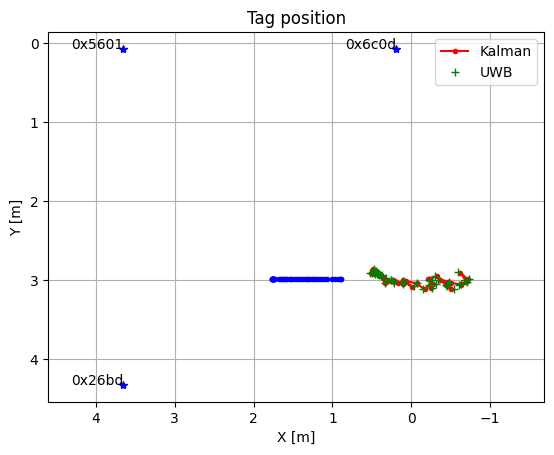

In [18]:
import matplotlib.pyplot as plt
x, y = zip(*filtered_pos)


plt.plot(x, y, "r.-") # Kalman
plt.plot((df.x).to_list(), (df.y).to_list(), "g+") # UWB
# plt.axvline(1.560, ls=":") # Ground truth

from data.points import TAG
plt.plot((df.reference_distance).to_list(), [TAG["P3"].y/1000 for _ in range(len(df.reference_distance))], "b.")

plt.plot(a_x, a_y, "b*")
ax = plt.gca()
for x, y, label in zip(a_x, a_y, a_labels):
    ax.annotate(label, (x,y), horizontalalignment="right")

plt.axis('equal')
plt.legend(["Kalman", "UWB"])
plt.title("Tag position")
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.grid(True, "both")
# data[["acc_x", "acc_y"]].plot.line()

ax.invert_xaxis()
ax.invert_yaxis()
plt.show()

In [19]:
import plotly.express as px

x, y = zip(*filtered_acc)
px.line(y=[x, y, df.acc_x, df.acc_y])

In [20]:
from math import sqrt
# Distance between the line and trajectory
# ax + by + c = 0

# a = 1
# b = 0
# c = -1.560

# def point_line_distance(x, y, a, b, c):
#     return abs(a*x + b*y + c)/sqrt(a**2+b**2)
def p2p_dist(ax, ay, bx, by):
    return sqrt((bx-ax)**2 + (by-ay)**2)

# calc_dist = lambda x: point_line_distance(x[0],x[1],a,b,c)
calc_dist = p2p_dist()

kalman_df = pd.DataFrame({"x": [v for v, _ in filtered_pos], "y": [v for _, v in filtered_pos]})
kalman_df["error"] = kalman_df.apply(calc_dist, axis=1)
df["error"] = df[["x", "y"]].apply(calc_dist, axis=1)

errors = pd.concat([kalman_df["error"], df["error"]], axis=1, keys=['Kalman (UWB+accelerometer)', 'UWB'])
px.line(errors, markers=".", title="Error over samples", labels={"value": "Error", "variable": "Method", "index": "Sample index"})

TypeError: p2p_dist() missing 4 required positional arguments: 'ax', 'ay', 'bx', and 'by'